In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import scipy
import math
import pandas_ta as ta

import pickle

def find_levels( 
        price: np.array, atr: float, # Log closing price, and log atr 
        first_w: float = 0.1, 
        atr_mult: float = 3.0, 
        prom_thresh: float = 0.1
):

    # Setup weights
    last_w = 1.0
    w_step = (last_w - first_w) / len(price)
    weights = first_w + np.arange(len(price)) * w_step
    weights[weights < 0] = 0.0

    # Get kernel of price. 
    kernal = scipy.stats.gaussian_kde(price, bw_method=atr*atr_mult, weights=weights)

    # Construct market profile
    min_v = np.min(price)
    max_v = np.max(price)
    step = (max_v - min_v) / 200
    price_range = np.arange(min_v, max_v, step)
    pdf = kernal(price_range) # Market profile

    # Find significant peaks in the market profile
    pdf_max = np.max(pdf)
    prom_min = pdf_max * prom_thresh

    peaks, props = scipy.signal.find_peaks(pdf, prominence=prom_min)
    levels = [] 
    for peak in peaks:
        levels.append(np.exp(price_range[peak]))

    return levels, peaks, props, price_range, pdf, weights




def support_resistance_levels(
        data: pd.DataFrame, lookback: int, 
        first_w: float = 0.01, atr_mult:float=3.0, prom_thresh:float =0.25
):

    # Get log average true range, 
    atr = ta.atr(np.log(data['high']), np.log(data['low']), np.log(data['close']), lookback)

    all_levels = [None] * len(data)
    for i in range(lookback, len(data)):
        i_start  = i - lookback
        vals = np.log(data.iloc[i_start+1: i+1]['close'].to_numpy())
        levels, peaks, props, price_range, pdf, weights= find_levels(vals, atr.iloc[i], first_w, atr_mult, prom_thresh)
        all_levels[i] = levels
        
    return all_levels

def sr_penetration_signal(data: pd.DataFrame, levels: list):
    signal = np.zeros(len(data))
    curr_sig = 0.0
    close_arr = data['close'].to_numpy()
    for i in range(1, len(data)):
        if levels[i] is None:
            continue

        last_c = close_arr[i - 1]
        curr_c = close_arr[i]

        
        for level in levels[i]:
            if curr_c > level and last_c <= level: # Close cross above line
                curr_sig = 1.0
            elif curr_c < level and last_c >= level: # Close cross below line
                curr_sig = -1.0

        signal[i] = curr_sig
    return signal

def get_trades_from_signal(data: pd.DataFrame, signal: np.array):
    long_trades = []
    short_trades = []

    close_arr = data['close'].to_numpy()
    last_sig = 0.0
    open_trade = None
    idx = data.index
    for i in range(len(data)):
        if signal[i] == 1.0 and last_sig != 1.0: # Long entry
            if open_trade is not None:
                open_trade[2] = idx[i] 
                open_trade[3] = close_arr[i]
                short_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        if signal[i] == -1.0  and last_sig != -1.0: # Short entry
            if open_trade is not None:
                open_trade[2] = idx[i] 
                open_trade[3] = close_arr[i]
                long_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]

        last_sig = signal[i]

    long_trades = pd.DataFrame(long_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])
    short_trades = pd.DataFrame(short_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])

    long_trades['percent'] = (long_trades['exit_price'] - long_trades['entry_price']) / long_trades['entry_price'] 
    short_trades['percent'] = -1 * (short_trades['exit_price'] - short_trades['entry_price']) / short_trades['entry_price']
    long_trades = long_trades.set_index('entry_time')
    short_trades = short_trades.set_index('entry_time')
    return long_trades, short_trades 



In [2]:
if __name__ == '__main__':
    import pandas as pd
    import numpy as np
    import os
    from datetime import datetime, timedelta
    
    # List of asset files to process
    asset_files = ['BTCUSD.csv', 'ETHUSD.csv', 'EURUSD.csv', 'USDJPY.csv']  # Add all your asset files
    
    # Dictionary to categorize assets
    crypto_assets = ['BTCUSD', 'ETHUSD']
    forex_assets = ['EURUSD', 'USDJPY']
    
    # Grid search parameters
    first_w_range = np.arange(0.1, 1.5, 0.2)
    atr_mult_range = np.arange(2.0, 6.0, 0.25)
    
    # Analysis period
    start_date = '2025-01-01'
    end_date = '2025-03-01'
    
    # Dictionary to store best parameters for each asset
    best_asset_parameters = {}
    
    # Process each asset
    for asset_file in asset_files:
        asset_name = asset_file.replace('.csv', '')
        print(f"\nGrid search for {asset_name}")
        
        # Load data
        data = pd.read_csv(asset_file)
        
        # Convert date column to datetime
        data['date'] = pd.to_datetime(data['date'])
        data.set_index('date', inplace=True)
        data.sort_index(inplace=True)
        
        # Determine lookback period based on asset type
        if asset_name in crypto_assets:
            lookback = 720  # 15min intervals for crypto (8 days)
            pre_period_days = 8  # Days of data needed before start_date
        elif asset_name in forex_assets:
            lookback = 2000  # For forex
            pre_period_days = 30  # Approximately 1 month
        else:
            lookback = 720  # Default
            pre_period_days = 8
        
        # Calculate the required start date for pre-period
        pre_start_date = pd.to_datetime(start_date) - timedelta(days=pre_period_days)
        
        # Filter data for the required period (pre-period + analysis period)
        full_data = data[(data.index >= pre_start_date) & (data.index < end_date)].copy()
        
        # Ensure we have enough data for lookback
        if len(full_data) < lookback:
            print(f"Warning: Not enough data for {asset_name}. Required: {lookback}, Available: {len(full_data)}")
            continue
        
        # Dictionary to store results for different parameter combinations
        parameter_results = {}
        
        # Nested loops to iterate through parameter combinations
        for first_w in first_w_range:
            for atr_mult in atr_mult_range:
                # Compute support & resistance levels on full data
                print(f"Processing {asset_name} with first_w={first_w}, atr_mult={atr_mult}...")
                levels = support_resistance_levels(full_data, lookback, first_w=first_w, atr_mult=atr_mult)
                
                # Filter to analysis period only for signal generation and returns
                analysis_data = full_data[(full_data.index >= start_date) & (full_data.index < end_date)].copy()
                
                # Extract corresponding levels for analysis period
                analysis_levels = levels[-len(analysis_data):]
                
                # Generate signals
                analysis_data['sr_signal'] = sr_penetration_signal(analysis_data, analysis_levels)
                analysis_data['log_ret'] = np.log(analysis_data['close']).diff().shift(-1)
                analysis_data['sr_return'] = analysis_data['sr_signal'] * analysis_data['log_ret']
                
                # Get trades
                long_trades, short_trades = get_trades_from_signal(analysis_data, analysis_data['sr_signal'].to_numpy())
                
                # Calculate final equity
                initial_balance = 10000
                total_equity = [initial_balance]
                
                # Merge long and short trades
                all_trades = pd.concat([long_trades, short_trades]).sort_index()
                
                for i in range(len(all_trades)):
                    new_balance = total_equity[-1] * (1 + all_trades["percent"].iloc[i] / 100)
                    total_equity.append(new_balance)
                
                final_equity = total_equity[-1]
                
                # Store results for this parameter combination
                parameter_results[(first_w, atr_mult)] = final_equity
        
        # Find the best parameter combination for this asset
        if parameter_results:  # Check if we have any results
            best_params = max(parameter_results, key=parameter_results.get)
            best_final_equity = parameter_results[best_params]
            
            # Store best parameters for this asset
            best_asset_parameters[asset_name] = {
                "lookback": lookback,
                "first_w": best_params[0],
                "atr_mult": best_params[1],
                "final_equity": best_final_equity,
                "num_trades": len(all_trades) if 'all_trades' in locals() else 0
            }
    
    # Print results for each asset
    print("\nBest Parameters for Each Asset:")
    for asset, params in best_asset_parameters.items():
        print(f"\n{asset}:")
        print(f"  Lookback Period: {params['lookback']}")
        print(f"  First W: {params['first_w']}")
        print(f"  ATR Mult: {params['atr_mult']}")
        print(f"  Final Equity: {params['final_equity']}")
        print(f"  Number of Trades: {params['num_trades']}")


Grid search for BTCUSD
Processing BTCUSD with first_w=0.1, atr_mult=2.0...
Processing BTCUSD with first_w=0.1, atr_mult=2.25...


KeyboardInterrupt: 

# Validation Phase

## Running backtest

In [2]:
if __name__ == '__main__':
    import pandas as pd
    import numpy as np
    import os
    from datetime import datetime, timedelta
    
    # List of asset files to process
    asset_files = ['BTCUSD.csv', 'ETHUSD.csv', 'EURUSD.csv', 'USDJPY.csv']  # Add all your asset files
    
    # Dictionary to categorize assets
    crypto_assets = ['BTCUSD', 'ETHUSD']
    forex_assets = ['EURUSD', 'USDJPY']
    
    # Analysis period
    start_date = '2025-01-01'
    end_date = '2025-03-01'
    
    # Dictionary to store trade results for each asset
    trade_results = {}
    
    # Process each asset
    for asset_file in asset_files:
        asset_name = asset_file.replace('.csv', '')
        print(f"Processing {asset_name}...")
        
        # Load data
        data = pd.read_csv(asset_file)
        
        # Convert date column to datetime
        data['date'] = pd.to_datetime(data['date'])
        data.set_index('date', inplace=True)
        data.sort_index(inplace=True)
        
        # Determine lookback period based on asset type
        if asset_name == "BTCUSD":
            lookback = 720  # For crypto
            first_w = 0.1 # Example parameter for crypto
            atr_mult = 2.75  # Example parameter for crypto
        elif asset_name == "ETHUSD":
            lookback = 720  # For forex
            first_w = 0.1  # Example parameter for forex
            atr_mult = 3.75  # Example parameter for forex
        elif asset_name == "EURUSD":
            lookback = 2000  # For forex
            first_w = 1.3  # Example parameter for forex
            atr_mult = 3.0  # Example parameter for forex
        elif asset_name == "USDJPY":
            lookback = 2000  # For forex
            first_w = 1.3  # Example parameter for forex
            atr_mult = 5.5  # Example parameter for forex
        
        # Calculate the required start date for pre-period
        if asset_name in crypto_assets:
            pre_period_days = 8  # For crypto (720 periods at 15min intervals)
        else:
            pre_period_days = 30  # For forex (approx 1 month for 2000 periods)
            
        pre_start_date = pd.to_datetime(start_date) - timedelta(days=pre_period_days)
        
        # Filter data for the required period (pre-period + analysis period)
        full_data = data[(data.index >= pre_start_date) & (data.index < end_date)].copy()
        data = data.sort_index()
        # Ensure we have enough data for lookback
        if len(full_data) < lookback:
            print(f"Warning: Not enough data for {asset_name}. Required: {lookback}, Available: {len(full_data)}")
            continue
        
        # Get the analysis period data
        analysis_data = full_data[(full_data.index >= start_date) & (full_data.index < end_date)].copy()
        
        # Compute support & resistance levels
        print(f"Computing levels for {asset_name} with lookback={lookback}, first_w={first_w}, atr_mult={atr_mult}")
        levels = support_resistance_levels(full_data, lookback, first_w=first_w, atr_mult=atr_mult)
        
        # Extract corresponding levels for analysis period
        analysis_levels = levels[-len(analysis_data):]
        
        # Generate signals
        analysis_data['sr_signal'] = sr_penetration_signal(analysis_data, analysis_levels)
        analysis_data['log_ret'] = np.log(analysis_data['close']).diff().shift(-1)
        analysis_data['sr_return'] = analysis_data['sr_signal'] * analysis_data['log_ret']
        
        # Get trades
        long_trades, short_trades = get_trades_from_signal(analysis_data, analysis_data['sr_signal'].to_numpy())
        
        # Calculate some basic statistics
        num_long = len(long_trades)
        num_short = len(short_trades)
        avg_long_return = long_trades['percent'].mean() if num_long > 0 else 0
        avg_short_return = short_trades['percent'].mean() if num_short > 0 else 0
        
        print(f"  {asset_name} results: {num_long} long trades, {num_short} short trades")
        print(f"  Avg long return: {avg_long_return:.2f}%, Avg short return: {avg_short_return:.2f}%")
        
        # Store results
        trade_results[asset_name] = {
            "long_trades": long_trades, 
            "short_trades": short_trades,
            "lookback": lookback,
            "first_w": first_w,
            "atr_mult": atr_mult
        }
    
    # Print summary
    print("\nTrade Results Summary:")
    for asset, results in trade_results.items():
        long_profit = results["long_trades"]["percent"].sum() if len(results["long_trades"]) > 0 else 0
        short_profit = results["short_trades"]["percent"].sum() if len(results["short_trades"]) > 0 else 0
        total_profit = long_profit + short_profit
        
        print(f"\n{asset}:")
        print(f"  Parameters: lookback={results['lookback']}, first_w={results['first_w']}, atr_mult={results['atr_mult']}")
        print(f"  Long trades: {len(results['long_trades'])}, Profit: {long_profit:.2f}%")
        print(f"  Short trades: {len(results['short_trades'])}, Profit: {short_profit:.2f}%")
        print(f"  Total profit: {total_profit:.2f}%")

Processing BTCUSD...
Computing levels for BTCUSD with lookback=720, first_w=0.1, atr_mult=2.75
  BTCUSD results: 534 long trades, 534 short trades
  Avg long return: 0.00%, Avg short return: 0.00%
Processing ETHUSD...
Computing levels for ETHUSD with lookback=720, first_w=0.1, atr_mult=3.75
  ETHUSD results: 385 long trades, 386 short trades
  Avg long return: 0.00%, Avg short return: 0.00%
Processing EURUSD...
Computing levels for EURUSD with lookback=2000, first_w=1.3, atr_mult=3.0
  EURUSD results: 198 long trades, 197 short trades
  Avg long return: -0.00%, Avg short return: -0.00%
Processing USDJPY...
Computing levels for USDJPY with lookback=2000, first_w=1.3, atr_mult=5.5
  USDJPY results: 156 long trades, 156 short trades
  Avg long return: -0.00%, Avg short return: 0.00%

Trade Results Summary:

BTCUSD:
  Parameters: lookback=720, first_w=0.1, atr_mult=2.75
  Long trades: 534, Profit: 0.03%
  Short trades: 534, Profit: 0.09%
  Total profit: 0.12%

ETHUSD:
  Parameters: lookbac

### BTCUSD

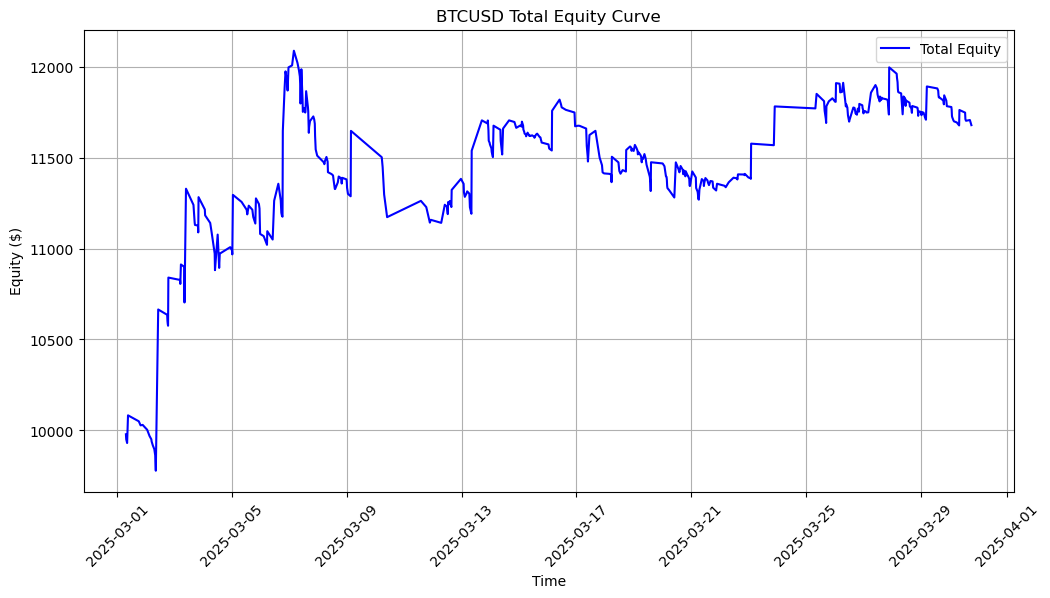

Annual Return: 2.1124
Sharpe Ratio: 0.7646
Max Drawdown: 0.0783
Win Rate: 0.2783
Annual Volatility: 0.1258
Number of Trades: 442
Average Holding Period (mins): 96.04
Profit per Trade: 3.7972


In [ ]:
# Assuming trade_results is a dictionary with the trade data
# Rename the dataframes for clarity
long_trades_btc = trade_results["BTCUSD"]["long_trades"].sort_index()
short_trades_btc = trade_results["BTCUSD"]["short_trades"].sort_index()

trades_btc = pd.concat([long_trades_btc, short_trades_btc]).sort_index()

# Initial balance
initial_balance = 10000

# Compute total equity curve
total_equity_btc = [initial_balance]
for percent_change in trades_btc['percent']:
    new_balance = total_equity_btc[-1] * (1 + percent_change)
    total_equity_btc.append(new_balance)

# Create a DataFrame for plotting the total equity curve
total_equity_curve_btc = pd.DataFrame({"time": trades_btc.index, "equity": total_equity_btc[1:]})

# Plot the equity curve
plt.figure(figsize=(12, 6))
plt.plot(total_equity_curve_btc["time"], total_equity_curve_btc["equity"], label="Total Equity", color="blue")
plt.xlabel("Time")
plt.ylabel("Equity ($)")
plt.title("BTCUSD Total Equity Curve")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()
# Calculate duration of each trade in minutes
trades_btc['trade_duration'] = (trades_btc['exit_time'] - trades_btc.index).dt.total_seconds() / 60

# Now calculate average holding period in minutes
average_holding_period_minutes = trades_btc['trade_duration'].mean()
# Calculate trading statistics
days_traded = (trades_btc.index[-1] - trades_btc.index[0]).days
annual_return =  (total_equity_btc[-1] / initial_balance - 1) * (365 / days_traded)
daily_returns = np.diff(total_equity_btc) / total_equity_btc[:-1]
annual_volatility = trades_btc['percent'].std() * np.sqrt(252)  # Assuming 252 trading days
sharpe_ratio = (np.mean(daily_returns) / np.std(daily_returns)) * np.sqrt(252)
rolling_max = np.maximum.accumulate(total_equity_btc)
drawdowns = (rolling_max - total_equity_btc) / rolling_max
max_drawdown = np.max(drawdowns)
wins = sum(np.diff(total_equity_btc) > 0)
win_rate = wins / len(trades_btc)
number_of_trades = len(trades_btc)
average_holding_period = days_traded / number_of_trades
profit_per_trade = np.mean(np.diff(total_equity_btc))

# Print statistics
print(f"Annual Return: {annual_return:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Max Drawdown: {max_drawdown:.4f}")
print(f"Win Rate: {win_rate:.4f}")
print(f"Annual Volatility: {annual_volatility:.4f}")
print(f"Number of Trades: {number_of_trades}")
print(f"Average Holding Period (mins): {average_holding_period_minutes:.2f}")
print(f"Profit per Trade: {profit_per_trade:.4f}")


In [31]:
trades_btc

,entry_price,exit_time,exit_price,percent,trade_duration
entry_time,,,,,
2025-03-01 07:15:00,84471.37,2025-03-01 07:30:00,84651.48,-0.002132,15.0
2025-03-01 07:30:00,84651.48,2025-03-01 08:15:00,84417.38,-0.002765,45.0
2025-03-01 08:15:00,84417.38,2025-03-01 09:00:00,84590.03,-0.002045,45.0
2025-03-01 09:00:00,84590.03,2025-03-01 18:00:00,85885.28,0.015312,540.0
2025-03-01 18:00:00,85885.28,2025-03-01 19:30:00,86163.32,-0.003237,90.0
...,...,...,...,...,...
2025-03-30 13:15:00,82473.00,2025-03-30 13:30:00,82372.00,-0.001225,15.0
2025-03-30 13:30:00,82372.00,2025-03-30 14:00:00,82625.00,-0.003071,30.0
2025-03-30 14:00:00,82625.00,2025-03-30 17:15:00,82563.00,-0.000750,195.0


### ETHUSD

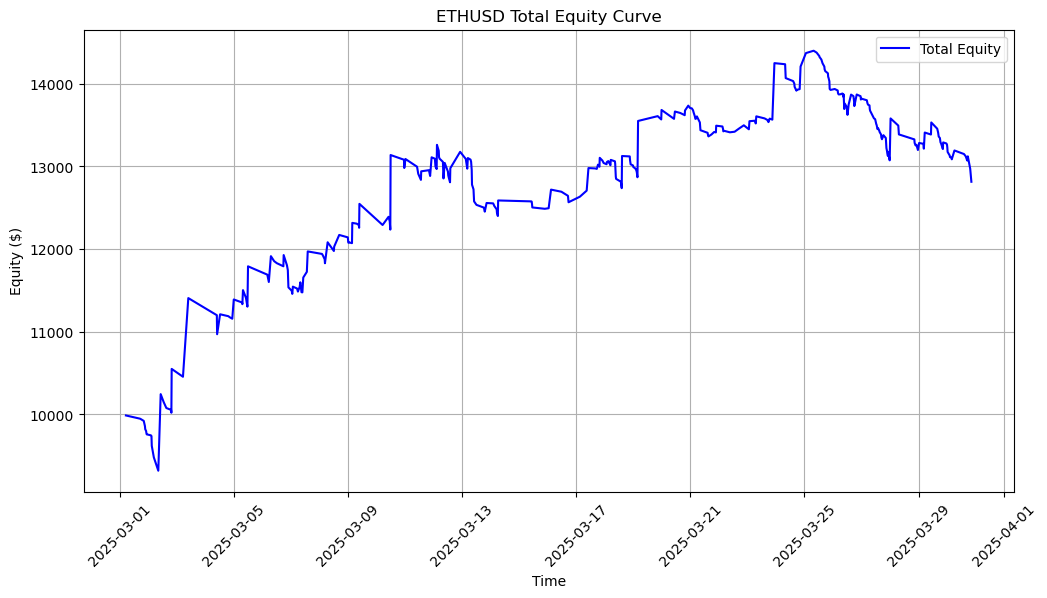

Annual Return: 21.6664
Sharpe Ratio: 1.0344
Max Drawdown: 0.1101
Win Rate: 0.2653
Annual Volatility: 0.1937
Number of Trades: 343
Average Holding Period (mins): 124.55
Profit per Trade: 8.2044


In [ ]:

long_trades_eth = trade_results["ETHUSD"]["long_trades"].sort_index()
short_trades_eth = trade_results["ETHUSD"]["short_trades"].sort_index()

trades_eth = pd.concat([long_trades_eth, short_trades_eth]).sort_index()

# Initial balance
initial_balance = 10000

# Compute total equity curve
total_equity_eth = [initial_balance]
for percent_change in trades_eth['percent']:
    new_balance = total_equity_eth[-1] * (1 + percent_change)
    total_equity_eth.append(new_balance)

# Create a DataFrame for plotting the total equity curve
total_equity_curve_eth = pd.DataFrame({"time": trades_eth.index, "equity": total_equity_eth[1:]})

# Plot the equity curve
plt.figure(figsize=(12, 6))
plt.plot(total_equity_curve_eth["time"], total_equity_curve_eth["equity"], label="Total Equity", color="blue")
plt.xlabel("Time")
plt.ylabel("Equity ($)")
plt.title("ETHUSD Total Equity Curve")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Calculate duration of each trade in minutes
trades_eth['trade_duration'] = (trades_eth['exit_time'] - trades_eth.index).dt.total_seconds() / 60

# Now calculate average holding period in minutes
average_holding_period_minutes = trades_eth['trade_duration'].mean()

# Calculate trading statistics
days_traded = (trades_eth.index[-1] - trades_eth.index[0]).days
annual_return = ((total_equity_eth[-1] / initial_balance) ** (365 / days_traded)) - 1
daily_returns = np.diff(total_equity_eth) / total_equity_eth[:-1]
annual_volatility = trades_eth['percent'].std() * np.sqrt(252)  # Assuming 252 trading days
sharpe_ratio = (np.mean(daily_returns) / np.std(daily_returns)) * np.sqrt(252)
rolling_max = np.maximum.accumulate(total_equity_eth)
drawdowns = (rolling_max - total_equity_eth) / rolling_max
max_drawdown = np.max(drawdowns)
wins = sum(np.diff(total_equity_eth) > 0)
win_rate = wins / len(trades_eth)
number_of_trades = len(trades_eth)
average_holding_period = days_traded / number_of_trades
profit_per_trade = np.mean(np.diff(total_equity_eth))

# Print statistics
print(f"Annual Return: {annual_return:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Max Drawdown: {max_drawdown:.4f}")
print(f"Win Rate: {win_rate:.4f}")
print(f"Annual Volatility: {annual_volatility:.4f}")
print(f"Number of Trades: {number_of_trades}")
print(f"Average Holding Period (mins): {average_holding_period_minutes:.2f}")
print(f"Profit per Trade: {profit_per_trade:.4f}")


### EURUSD

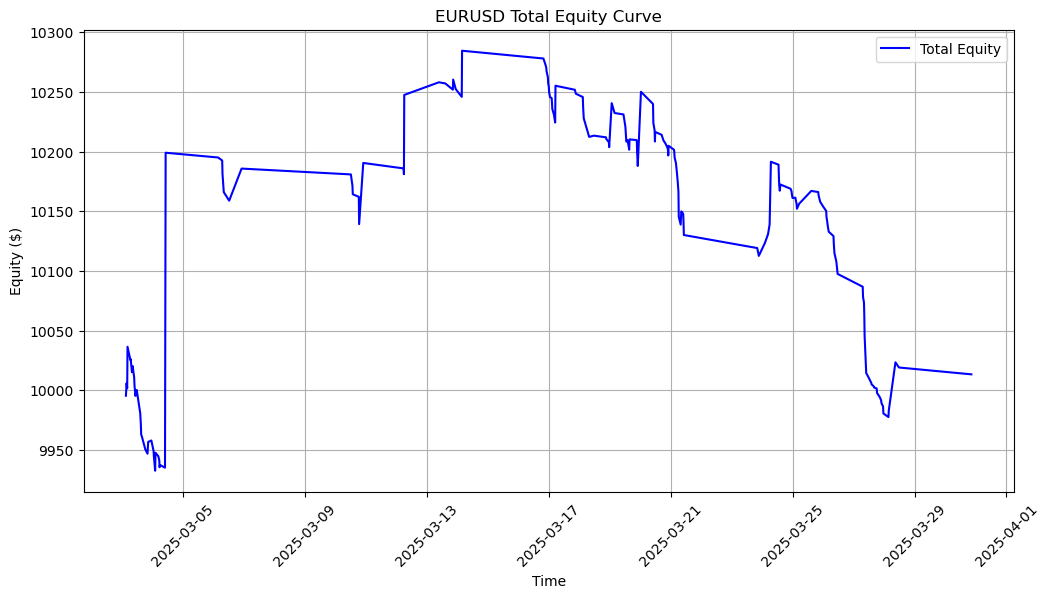

Annual Return: 0.0183
Sharpe Ratio: 0.0686
Max Drawdown: 0.0298
Win Rate: 0.2000
Annual Volatility: 0.0373
Number of Trades: 180
Average Holding Period (mins): 222.17
Profit per Trade: 0.0744


In [ ]:

long_trades_eurusd = trade_results["EURUSD"]["long_trades"].sort_index()
short_trades_eurusd = trade_results["EURUSD"]["short_trades"].sort_index()

trades_eurusd = pd.concat([long_trades_eurusd, short_trades_eurusd]).sort_index()

# Initial balance
initial_balance = 10000

# Compute total equity curve
total_equity_eurusd = [initial_balance]
for percent_change in trades_eurusd['percent']:
    new_balance = total_equity_eurusd[-1] * (1 + percent_change)
    total_equity_eurusd.append(new_balance)

# Create a DataFrame for plotting the total equity curve
total_equity_curve_eurusd = pd.DataFrame({"time": trades_eurusd.index, "equity": total_equity_eurusd[1:]})

# Plot the equity curve
plt.figure(figsize=(12, 6))
plt.plot(total_equity_curve_eurusd["time"], total_equity_curve_eurusd["equity"], label="Total Equity", color="blue")
plt.xlabel("Time")
plt.ylabel("Equity ($)")
plt.title("EURUSD Total Equity Curve")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Calculate duration of each trade in minutes
trades_eurusd['trade_duration'] = (trades_eurusd['exit_time'] - trades_eurusd.index).dt.total_seconds() / 60

# Now calculate average holding period in minutes
average_holding_period_minutes = trades_eurusd['trade_duration'].mean()

# Calculate trading statistics
days_traded = (trades_eurusd.index[-1] - trades_eurusd.index[0]).days
annual_return = ((total_equity_eurusd[-1] / initial_balance) ** (365 / days_traded)) - 1
daily_returns = np.diff(total_equity_eurusd) / total_equity_eurusd[:-1]
annual_volatility = trades_eurusd['percent'].std() * np.sqrt(252) # Assuming 252 trading days
sharpe_ratio = (np.mean(daily_returns) / np.std(daily_returns)) * np.sqrt(252)
rolling_max = np.maximum.accumulate(total_equity_eurusd)
drawdowns = (rolling_max - total_equity_eurusd) / rolling_max
max_drawdown = np.max(drawdowns)
wins = sum(np.diff(total_equity_eurusd) > 0)
win_rate = wins / len(trades_eurusd)
number_of_trades = len(trades_eurusd)
average_holding_period = days_traded / number_of_trades
profit_per_trade = np.mean(np.diff(total_equity_eurusd))

# Print statistics
print(f"Annual Return: {annual_return:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Max Drawdown: {max_drawdown:.4f}")
print(f"Win Rate: {win_rate:.4f}")
print(f"Annual Volatility: {annual_volatility:.4f}")
print(f"Number of Trades: {number_of_trades}")
print(f"Average Holding Period (mins): {average_holding_period_minutes:.2f}")
print(f"Profit per Trade: {profit_per_trade:.4f}")



### USDJPY

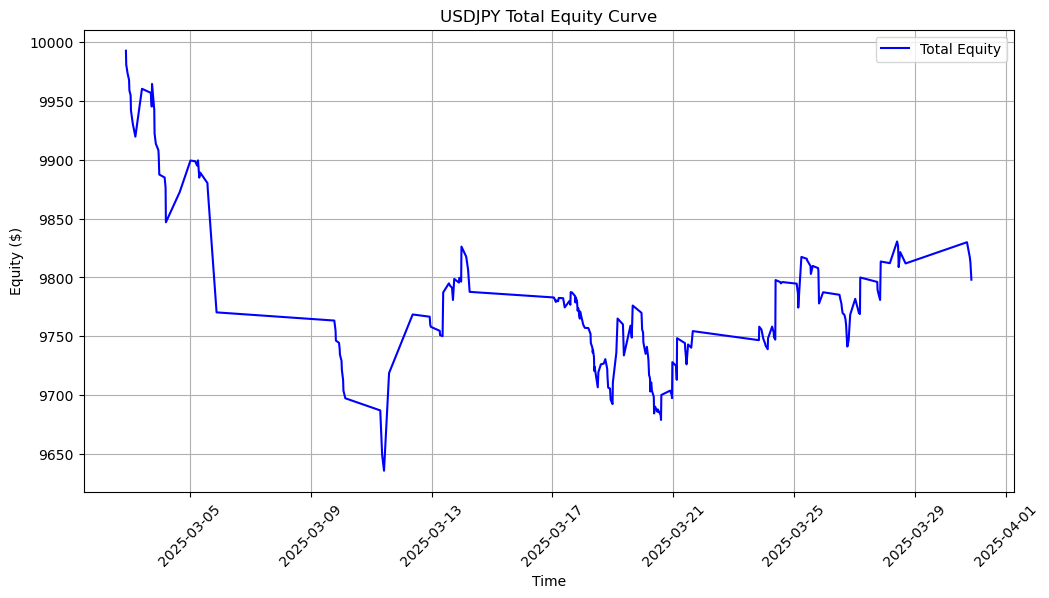

Annual Return: -0.2410
Sharpe Ratio: -0.8947
Max Drawdown: 0.0364
Win Rate: 0.2609
Annual Volatility: 0.0246
Number of Trades: 230
Average Holding Period (mins): 175.30
Profit per Trade: -0.8779


In [ ]:

long_trades_usdjpy = trade_results["USDJPY"]["long_trades"].sort_index()
short_trades_usdjpy = trade_results["USDJPY"]["short_trades"].sort_index()

trades_usdjpy = pd.concat([long_trades_usdjpy, short_trades_usdjpy]).sort_index()

# Initial balance
initial_balance = 10000

# Compute total equity curve
total_equity_usdjpy = [initial_balance]
for percent_change in trades_usdjpy['percent']:
    new_balance = total_equity_usdjpy[-1] * (1 + percent_change)
    total_equity_usdjpy.append(new_balance)

# Create a DataFrame for plotting the total equity curve
total_equity_curve_usdjpy = pd.DataFrame({"time": trades_usdjpy.index, "equity": total_equity_usdjpy[1:]})

# Plot the equity curve
plt.figure(figsize=(12, 6))
plt.plot(total_equity_curve_usdjpy["time"], total_equity_curve_usdjpy["equity"], label="Total Equity", color="blue")
plt.xlabel("Time")
plt.ylabel("Equity ($)")
plt.title("USDJPY Total Equity Curve")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Calculate duration of each trade in minutes
trades_usdjpy['trade_duration'] = (trades_usdjpy['exit_time'] - trades_usdjpy.index).dt.total_seconds() / 60

# Now calculate average holding period in minutes
average_holding_period_minutes = trades_usdjpy['trade_duration'].mean()

# Calculate trading statistics
days_traded = (trades_usdjpy.index[-1] - trades_usdjpy.index[0]).days
annual_return = ((total_equity_usdjpy[-1] / initial_balance) ** (365 / days_traded)) - 1
daily_returns = np.diff(total_equity_usdjpy) / total_equity_usdjpy[:-1]
annual_volatility = trades_usdjpy['percent'].std() * np.sqrt(252)  # Assuming 252 trading days
sharpe_ratio = (np.mean(daily_returns) / np.std(daily_returns)) * np.sqrt(252)
rolling_max = np.maximum.accumulate(total_equity_usdjpy)
drawdowns = (rolling_max - total_equity_usdjpy) / rolling_max
max_drawdown = np.max(drawdowns)
wins = sum(np.diff(total_equity_usdjpy) > 0)
win_rate = wins / len(trades_usdjpy)
number_of_trades = len(trades_usdjpy)
average_holding_period = days_traded / number_of_trades
profit_per_trade = np.mean(np.diff(total_equity_usdjpy))

# Print statistics
print(f"Annual Return: {annual_return:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Max Drawdown: {max_drawdown:.4f}")
print(f"Win Rate: {win_rate:.4f}")
print(f"Annual Volatility: {annual_volatility:.4f}")
print(f"Number of Trades: {number_of_trades}")
print(f"Average Holding Period (mins): {average_holding_period_minutes:.2f}")
print(f"Profit per Trade: {profit_per_trade:.4f}")


### As a whole:

In [32]:
BTCUSD_Optimal_curve = total_equity_curve_btc
ETHUSD_Optimal_curve = total_equity_curve_eth
EURUSD_Optimal_curve = total_equity_curve_eurusd
USDJPY_Optimal_curve = total_equity_curve_usdjpy

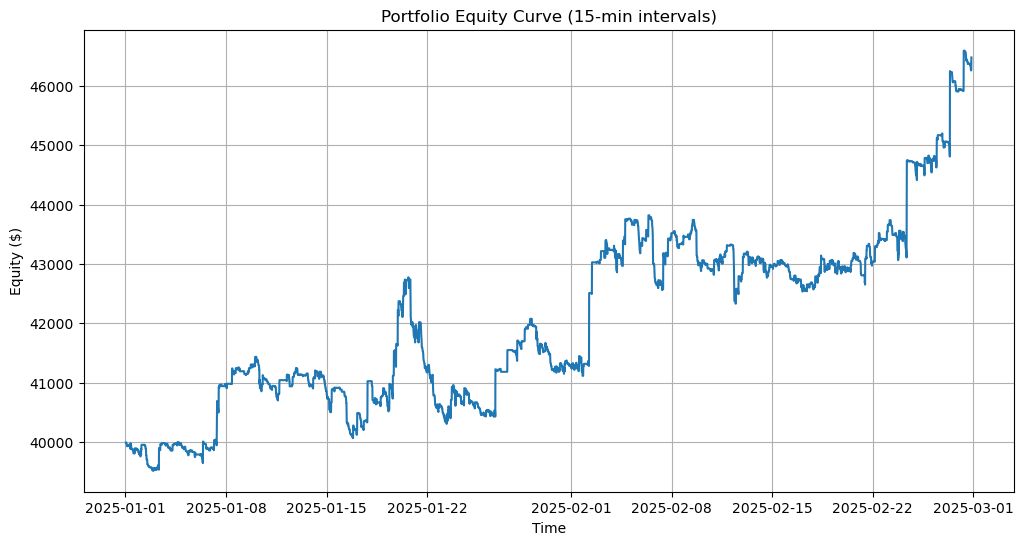

In [33]:
# 1. Concatenate all equity curves
combined = pd.concat([
    BTCUSD_Optimal_curve,
    ETHUSD_Optimal_curve,
    EURUSD_Optimal_curve,
    USDJPY_Optimal_curve
])

combined.to_csv("optimal_curves.csv")

# 2. Create a complete datetime index covering your entire period
full_index = pd.date_range(
    start=combined['time'].min(),
    end=combined['time'].max(),
    freq='15T'  # 15 minute intervals
)

# 3. For each asset, reindex to the full timeline and forward-fill
assets = {
    'BTC': BTCUSD_Optimal_curve,
    'ETH': ETHUSD_Optimal_curve,
    'EUR': EURUSD_Optimal_curve,
    'JPY': USDJPY_Optimal_curve
}

filled_curves = {}
for name, df in assets.items():
    # Set time as index and reindex to full timeline
    temp = df.set_index('time').reindex(full_index)
    # Forward fill equity values
    temp['equity'] = temp['equity'].ffill()
    # Backfill initial NaN values if needed
    temp['equity'] = temp['equity'].bfill()
    filled_curves[name] = temp.reset_index()

# 4. Combine all filled curves
combined_filled = pd.concat(filled_curves.values())
combined_filled
total_equity = combined_filled.groupby('index')['equity'].sum().reset_index()

# 5. Plot
plt.figure(figsize=(12, 6))
plt.plot(total_equity['index'], total_equity['equity'], label="Total Equity")
plt.xlabel("Time")
plt.ylabel("Equity ($)")
plt.title("Portfolio Equity Curve (15-min intervals)")
plt.grid()
plt.show()

# Testing Phase

In [40]:
if __name__ == '__main__':
    import pandas as pd
    import numpy as np
    import os
    from datetime import datetime, timedelta
    
    # List of asset files to process
    asset_files = ['BTCUSD.csv', 'ETHUSD.csv', 'EURUSD.csv', 'USDJPY.csv']  # Add all your asset files
    
    # Dictionary to categorize assets
    crypto_assets = ['BTCUSD', 'ETHUSD']
    forex_assets = ['EURUSD', 'USDJPY']
    
    # Analysis period
    start_date = '2025-03-01'
    end_date = '2025-03-31'
    
    # Dictionary to store trade results for each asset
    trade_results = {}
    
    # Process each asset
    for asset_file in asset_files:
        asset_name = asset_file.replace('.csv', '')
        print(f"Processing {asset_name}...")
        
        # Load data
        data = pd.read_csv(asset_file)
        
        # Convert date column to datetime
        data['date'] = pd.to_datetime(data['date'])
        data.set_index('date', inplace=True)
        data.sort_index(inplace=True)
        
        # Determine lookback period based on asset type
        if asset_name == "BTCUSD":
            lookback = 720  # For crypto
            first_w = 0.1 # Example parameter for crypto
            atr_mult = 2.75  # Example parameter for crypto
        elif asset_name == "ETHUSD":
            lookback = 720  # For forex
            first_w = 0.1  # Example parameter for forex
            atr_mult = 3.75  # Example parameter for forex
        elif asset_name == "EURUSD":
            lookback = 2000  # For forex
            first_w = 1.3  # Example parameter for forex
            atr_mult = 3.0  # Example parameter for forex
        elif asset_name == "USDJPY":
            lookback = 2000  # For forex
            first_w = 1.3  # Example parameter for forex
            atr_mult = 5.5  # Example parameter for forex
        
        # Calculate the required start date for pre-period
        if asset_name in crypto_assets:
            pre_period_days = 8  # For crypto (720 periods at 15min intervals)
        else:
            pre_period_days = 30  # For forex (approx 1 month for 2000 periods)
            
        pre_start_date = pd.to_datetime(start_date) - timedelta(days=pre_period_days)
        
        # Filter data for the required period (pre-period + analysis period)
        full_data = data[(data.index >= pre_start_date) & (data.index < end_date)].copy()
        data = data.sort_index()
        # Ensure we have enough data for lookback
        if len(full_data) < lookback:
            print(f"Warning: Not enough data for {asset_name}. Required: {lookback}, Available: {len(full_data)}")
            continue
        
        # Get the analysis period data
        analysis_data = full_data[(full_data.index >= start_date) & (full_data.index < end_date)].copy()
        
        # Compute support & resistance levels
        print(f"Computing levels for {asset_name} with lookback={lookback}, first_w={first_w}, atr_mult={atr_mult}")
        levels = support_resistance_levels(full_data, lookback, first_w=first_w, atr_mult=atr_mult)
        
        # Extract corresponding levels for analysis period
        analysis_levels = levels[-len(analysis_data):]
        
        # Generate signals
        analysis_data['sr_signal'] = sr_penetration_signal(analysis_data, analysis_levels)
        analysis_data['log_ret'] = np.log(analysis_data['close']).diff().shift(-1)
        analysis_data['sr_return'] = analysis_data['sr_signal'] * analysis_data['log_ret']
        
        # Get trades
        long_trades, short_trades = get_trades_from_signal(analysis_data, analysis_data['sr_signal'].to_numpy())
        
        # Calculate some basic statistics
        num_long = len(long_trades)
        num_short = len(short_trades)
        avg_long_return = long_trades['percent'].mean() if num_long > 0 else 0
        avg_short_return = short_trades['percent'].mean() if num_short > 0 else 0
        
        print(f"  {asset_name} results: {num_long} long trades, {num_short} short trades")
        print(f"  Avg long return: {avg_long_return:.2f}%, Avg short return: {avg_short_return:.2f}%")
        
        # Store results
        trade_results[asset_name] = {
            "long_trades": long_trades, 
            "short_trades": short_trades,
            "lookback": lookback,
            "first_w": first_w,
            "atr_mult": atr_mult
        }
    
    # Print summary
    print("\nTrade Results Summary:")
    for asset, results in trade_results.items():
        long_profit = results["long_trades"]["percent"].sum() if len(results["long_trades"]) > 0 else 0
        short_profit = results["short_trades"]["percent"].sum() if len(results["short_trades"]) > 0 else 0
        total_profit = long_profit + short_profit
        
        print(f"\n{asset}:")
        print(f"  Parameters: lookback={results['lookback']}, first_w={results['first_w']}, atr_mult={results['atr_mult']}")
        print(f"  Long trades: {len(results['long_trades'])}, Profit: {long_profit:.2f}%")
        print(f"  Short trades: {len(results['short_trades'])}, Profit: {short_profit:.2f}%")
        print(f"  Total profit: {total_profit:.2f}%")

Processing BTCUSD...
Computing levels for BTCUSD with lookback=720, first_w=0.1, atr_mult=2.75
  BTCUSD results: 221 long trades, 221 short trades
  Avg long return: 0.00%, Avg short return: 0.00%
Processing ETHUSD...
Computing levels for ETHUSD with lookback=720, first_w=0.1, atr_mult=3.75
  ETHUSD results: 171 long trades, 172 short trades
  Avg long return: 0.00%, Avg short return: 0.00%
Processing EURUSD...
Computing levels for EURUSD with lookback=2000, first_w=1.3, atr_mult=3.0
  EURUSD results: 90 long trades, 90 short trades
  Avg long return: 0.00%, Avg short return: -0.00%
Processing USDJPY...
Computing levels for USDJPY with lookback=2000, first_w=1.3, atr_mult=5.5
  USDJPY results: 115 long trades, 115 short trades
  Avg long return: -0.00%, Avg short return: -0.00%

Trade Results Summary:

BTCUSD:
  Parameters: lookback=720, first_w=0.1, atr_mult=2.75
  Long trades: 221, Profit: 0.08%
  Short trades: 221, Profit: 0.09%
  Total profit: 0.17%

ETHUSD:
  Parameters: lookback=

### BTCUSD

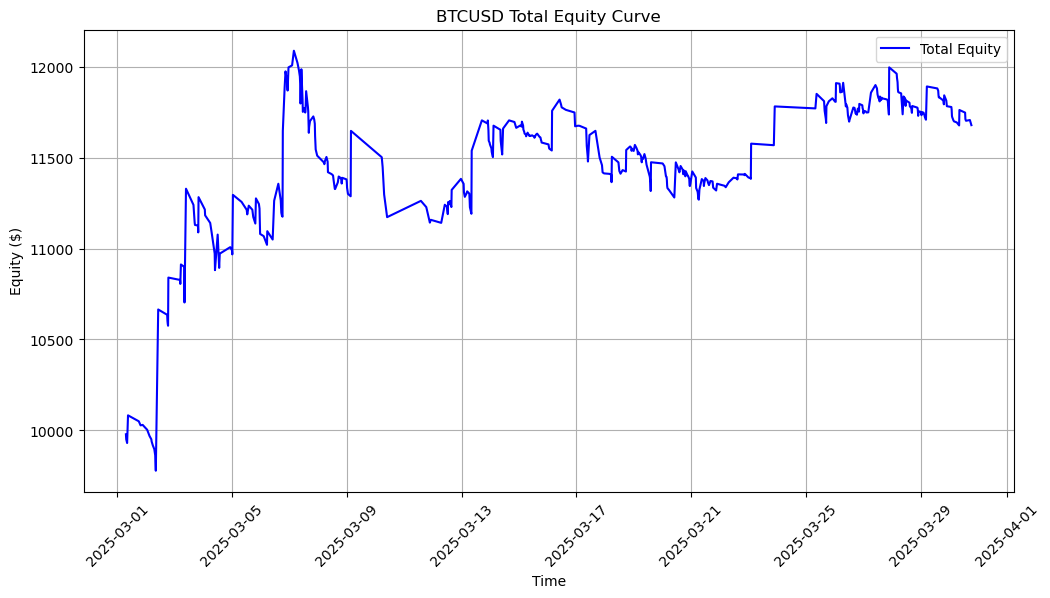

Annual Return: 2.1124
Sharpe Ratio: 0.7646
Max Drawdown: 0.0783
Win Rate: 0.2783
Annual Volatility: 0.1258
Number of Trades: 442
Average Holding Period (mins): 96.04
Profit per Trade: 0.0004


In [41]:
long_trades_btc = trade_results["BTCUSD"]["long_trades"].sort_index()
short_trades_btc = trade_results["BTCUSD"]["short_trades"].sort_index()

trades_btc = pd.concat([long_trades_btc, short_trades_btc]).sort_index()

# Initial balance
initial_balance = 10000

# Compute total equity curve
total_equity_btc = [initial_balance]
for percent_change in trades_btc['percent']:
    new_balance = total_equity_btc[-1] * (1 + percent_change)
    total_equity_btc.append(new_balance)

# Create a DataFrame for plotting the total equity curve
total_equity_curve_btc = pd.DataFrame({"time": trades_btc.index, "equity": total_equity_btc[1:]})

# Plot the equity curve
plt.figure(figsize=(12, 6))
plt.plot(total_equity_curve_btc["time"], total_equity_curve_btc["equity"], label="Total Equity", color="blue")
plt.xlabel("Time")
plt.ylabel("Equity ($)")
plt.title("BTCUSD Total Equity Curve")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()
# Calculate duration of each trade in minutes
trades_btc['trade_duration'] = (trades_btc['exit_time'] - trades_btc.index).dt.total_seconds() / 60

# Now calculate average holding period in minutes
average_holding_period_minutes = trades_btc['trade_duration'].mean()
# Calculate trading statistics
days_traded = (trades_btc.index[-1] - trades_btc.index[0]).days
annual_return =  (total_equity_btc[-1] / initial_balance - 1) * (365 / days_traded)
daily_returns = np.diff(total_equity_btc) / total_equity_btc[:-1]
annual_volatility = np.std(daily_returns) * np.sqrt(252)  # Assuming 252 trading days
sharpe_ratio = (np.mean(daily_returns) / np.std(daily_returns)) * np.sqrt(252)
rolling_max = np.maximum.accumulate(total_equity_btc)
drawdowns = (rolling_max - total_equity_btc) / rolling_max
max_drawdown = np.max(drawdowns)
wins = sum(np.diff(total_equity_btc) > 0)
win_rate = wins / len(trades_btc)
number_of_trades = len(trades_btc)
average_holding_period = days_traded / number_of_trades
profit_per_trade = trades_btc['percent'].mean()

# Print statistics
print(f"Annual Return: {annual_return:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Max Drawdown: {max_drawdown:.4f}")
print(f"Win Rate: {win_rate:.4f}")
print(f"Annual Volatility: {annual_volatility:.4f}")
print(f"Number of Trades: {number_of_trades}")
print(f"Average Holding Period (mins): {average_holding_period_minutes:.2f}")
print(f"Profit per Trade: {profit_per_trade:.4f}")

## ETHUSD

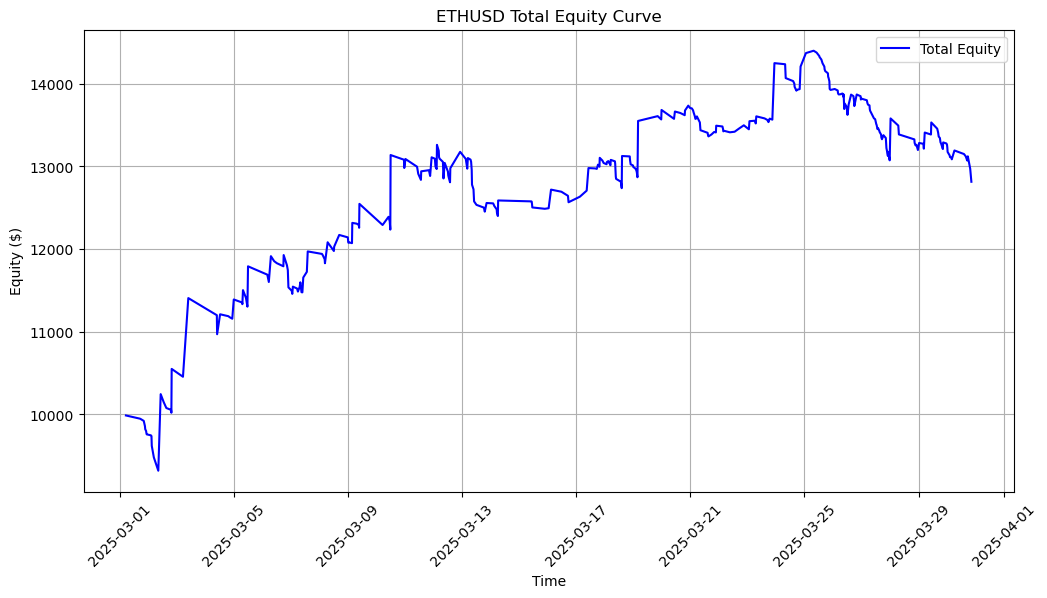

Annual Return: 3.5419
Sharpe Ratio: 1.0344
Max Drawdown: 0.1101
Win Rate: 0.2653
Annual Volatility: 0.1937
Number of Trades: 343
Average Holding Period (mins): 124.55
Profit per Trade: 0.0008


In [42]:
# Assuming trade_results is a dictionary with the trade data
# Rename the dataframes for clarity
long_trades_eth = trade_results["ETHUSD"]["long_trades"].sort_index()
short_trades_eth = trade_results["ETHUSD"]["short_trades"].sort_index()

trades_eth = pd.concat([long_trades_eth, short_trades_eth]).sort_index()

# Initial balance
initial_balance = 10000

# Compute total equity curve
total_equity_eth = [initial_balance]
for percent_change in trades_eth['percent']:
    new_balance = total_equity_eth[-1] * (1 + percent_change)
    total_equity_eth.append(new_balance)

# Create a DataFrame for plotting the total equity curve
total_equity_curve_eth = pd.DataFrame({"time": trades_eth.index, "equity": total_equity_eth[1:]})

# Plot the equity curve
plt.figure(figsize=(12, 6))
plt.plot(total_equity_curve_eth["time"], total_equity_curve_eth["equity"], label="Total Equity", color="blue")
plt.xlabel("Time")
plt.ylabel("Equity ($)")
plt.title("ETHUSD Total Equity Curve")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Calculate duration of each trade in minutes
trades_eth['trade_duration'] = (trades_eth['exit_time'] - trades_eth.index).dt.total_seconds() / 60

# Now calculate average holding period in minutes
average_holding_period_minutes = trades_eth['trade_duration'].mean()

# Calculate trading statistics
days_traded = (trades_eth.index[-1] - trades_eth.index[0]).days
annual_return = (total_equity_eth[-1] / initial_balance - 1) * (365 / days_traded)
daily_returns = np.diff(total_equity_eth) / total_equity_eth[:-1]
annual_volatility = np.std(daily_returns) * np.sqrt(252)  # Assuming 252 trading days
sharpe_ratio = (np.mean(daily_returns) / np.std(daily_returns)) * np.sqrt(252)
rolling_max = np.maximum.accumulate(total_equity_eth)
drawdowns = (rolling_max - total_equity_eth) / rolling_max
max_drawdown = np.max(drawdowns)
wins = sum(np.diff(total_equity_eth) > 0)
win_rate = wins / len(trades_eth)
number_of_trades = len(trades_eth)
average_holding_period = days_traded / number_of_trades
profit_per_trade = trades_eth['percent'].mean()

# Print statistics
print(f"Annual Return: {annual_return:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Max Drawdown: {max_drawdown:.4f}")
print(f"Win Rate: {win_rate:.4f}")
print(f"Annual Volatility: {annual_volatility:.4f}")
print(f"Number of Trades: {number_of_trades}")
print(f"Average Holding Period (mins): {average_holding_period_minutes:.2f}")
print(f"Profit per Trade: {profit_per_trade:.4f}")



## EURUSD

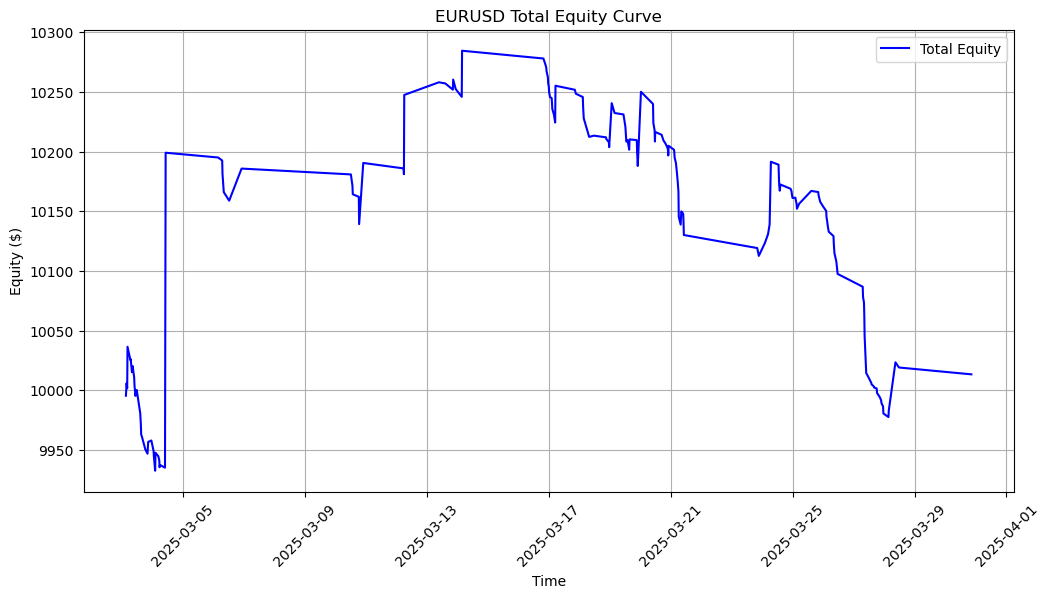

Annual Return: 0.0181
Sharpe Ratio: 0.0686
Max Drawdown: 0.0298
Win Rate: 0.2000
Annual Volatility: 0.0373
Number of Trades: 180
Average Holding Period (mins): 222.17
Profit per Trade: 0.0000


In [43]:
long_trades_eurusd = trade_results["EURUSD"]["long_trades"].sort_index()
short_trades_eurusd = trade_results["EURUSD"]["short_trades"].sort_index()

trades_eurusd = pd.concat([long_trades_eurusd, short_trades_eurusd]).sort_index()

# Initial balance
initial_balance = 10000

# Compute total equity curve
total_equity_eurusd = [initial_balance]
for percent_change in trades_eurusd['percent']:
    new_balance = total_equity_eurusd[-1] * (1 + percent_change)
    total_equity_eurusd.append(new_balance)

# Create a DataFrame for plotting the total equity curve
total_equity_curve_eurusd = pd.DataFrame({"time": trades_eurusd.index, "equity": total_equity_eurusd[1:]})

# Plot the equity curve
plt.figure(figsize=(12, 6))
plt.plot(total_equity_curve_eurusd["time"], total_equity_curve_eurusd["equity"], label="Total Equity", color="blue")
plt.xlabel("Time")
plt.ylabel("Equity ($)")
plt.title("EURUSD Total Equity Curve")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Calculate duration of each trade in minutes
trades_eurusd['trade_duration'] = (trades_eurusd['exit_time'] - trades_eurusd.index).dt.total_seconds() / 60

# Now calculate average holding period in minutes
average_holding_period_minutes = trades_eurusd['trade_duration'].mean()

# Calculate trading statistics
days_traded = (trades_eurusd.index[-1] - trades_eurusd.index[0]).days
annual_return = (total_equity_eurusd[-1] / initial_balance - 1) * (365 / days_traded)
daily_returns = np.diff(total_equity_eurusd) / total_equity_eurusd[:-1]
annual_volatility = np.std(daily_returns) * np.sqrt(252)  # Assuming 252 trading days
sharpe_ratio = (np.mean(daily_returns) / np.std(daily_returns)) * np.sqrt(252)
rolling_max = np.maximum.accumulate(total_equity_eurusd)
drawdowns = (rolling_max - total_equity_eurusd) / rolling_max
max_drawdown = np.max(drawdowns)
wins = sum(np.diff(total_equity_eurusd) > 0)
win_rate = wins / len(trades_eurusd)
number_of_trades = len(trades_eurusd)
average_holding_period = days_traded / number_of_trades
profit_per_trade = trades_eurusd['percent'].mean()

# Print statistics
print(f"Annual Return: {annual_return:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Max Drawdown: {max_drawdown:.4f}")
print(f"Win Rate: {win_rate:.4f}")
print(f"Annual Volatility: {annual_volatility:.4f}")
print(f"Number of Trades: {number_of_trades}")
print(f"Average Holding Period (mins): {average_holding_period_minutes:.2f}")
print(f"Profit per Trade: {profit_per_trade:.4f}")


## USDJPY

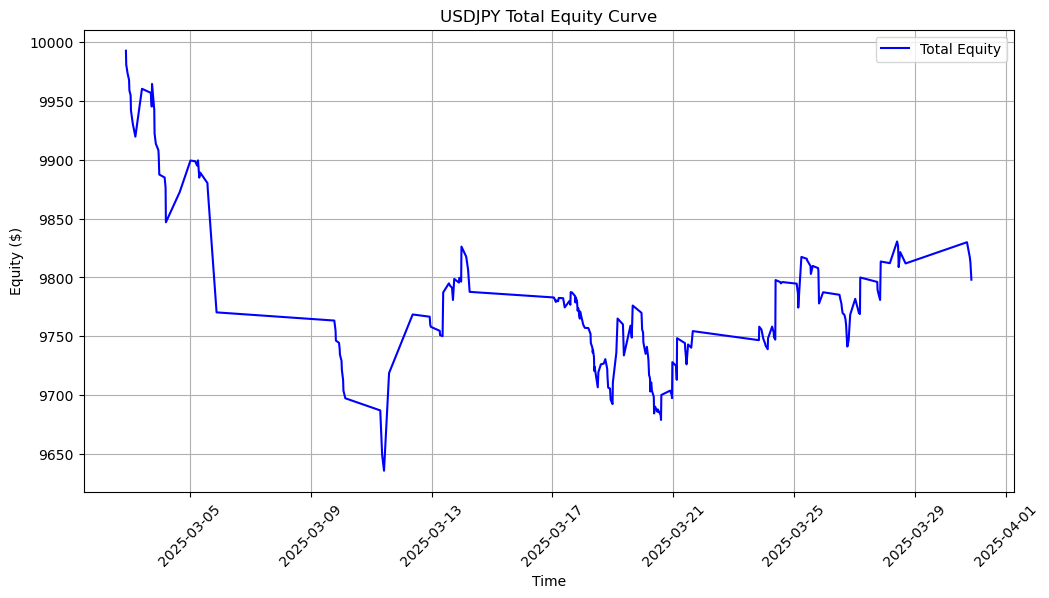

Annual Return: -0.2730
Sharpe Ratio: -0.8947
Max Drawdown: 0.0364
Win Rate: 0.2609
Annual Volatility: 0.0246
Number of Trades: 230
Average Holding Period (mins): 175.30
Profit per Trade: -0.0001


In [44]:
long_trades_usdjpy = trade_results["USDJPY"]["long_trades"].sort_index()
short_trades_usdjpy = trade_results["USDJPY"]["short_trades"].sort_index()

trades_usdjpy = pd.concat([long_trades_usdjpy, short_trades_usdjpy]).sort_index()

# Initial balance
initial_balance = 10000

# Compute total equity curve
total_equity_usdjpy = [initial_balance]
for percent_change in trades_usdjpy['percent']:
    new_balance = total_equity_usdjpy[-1] * (1 + percent_change)
    total_equity_usdjpy.append(new_balance)

# Create a DataFrame for plotting the total equity curve
total_equity_curve_usdjpy = pd.DataFrame({"time": trades_usdjpy.index, "equity": total_equity_usdjpy[1:]})

# Plot the equity curve
plt.figure(figsize=(12, 6))
plt.plot(total_equity_curve_usdjpy["time"], total_equity_curve_usdjpy["equity"], label="Total Equity", color="blue")
plt.xlabel("Time")
plt.ylabel("Equity ($)")
plt.title("USDJPY Total Equity Curve")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Calculate duration of each trade in minutes
trades_usdjpy['trade_duration'] = (trades_usdjpy['exit_time'] - trades_usdjpy.index).dt.total_seconds() / 60

# Now calculate average holding period in minutes
average_holding_period_minutes = trades_usdjpy['trade_duration'].mean()

# Calculate trading statistics
days_traded = (trades_usdjpy.index[-1] - trades_usdjpy.index[0]).days
annual_return = (total_equity_usdjpy[-1] / initial_balance - 1) * (365 / days_traded)
daily_returns = np.diff(total_equity_usdjpy) / total_equity_usdjpy[:-1]
annual_volatility = np.std(daily_returns) * np.sqrt(252)  # Assuming 252 trading days
sharpe_ratio = (np.mean(daily_returns) / np.std(daily_returns)) * np.sqrt(252)
rolling_max = np.maximum.accumulate(total_equity_usdjpy)
drawdowns = (rolling_max - total_equity_usdjpy) / rolling_max
max_drawdown = np.max(drawdowns)
wins = sum(np.diff(total_equity_usdjpy) > 0)
win_rate = wins / len(trades_usdjpy)
number_of_trades = len(trades_usdjpy)
average_holding_period = days_traded / number_of_trades
profit_per_trade = trades_usdjpy['percent'].mean()

# Print statistics
print(f"Annual Return: {annual_return:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Max Drawdown: {max_drawdown:.4f}")
print(f"Win Rate: {win_rate:.4f}")
print(f"Annual Volatility: {annual_volatility:.4f}")
print(f"Number of Trades: {number_of_trades}")
print(f"Average Holding Period (mins): {average_holding_period_minutes:.2f}")
print(f"Profit per Trade: {profit_per_trade:.4f}")

### Combining

In [24]:
BTCUSD_Optimal_curve = total_equity_curve_btc
ETHUSD_Optimal_curve = total_equity_curve_eth
EURUSD_Optimal_curve = total_equity_curve_eurusd
USDJPY_Optimal_curve = total_equity_curve_usdjpy

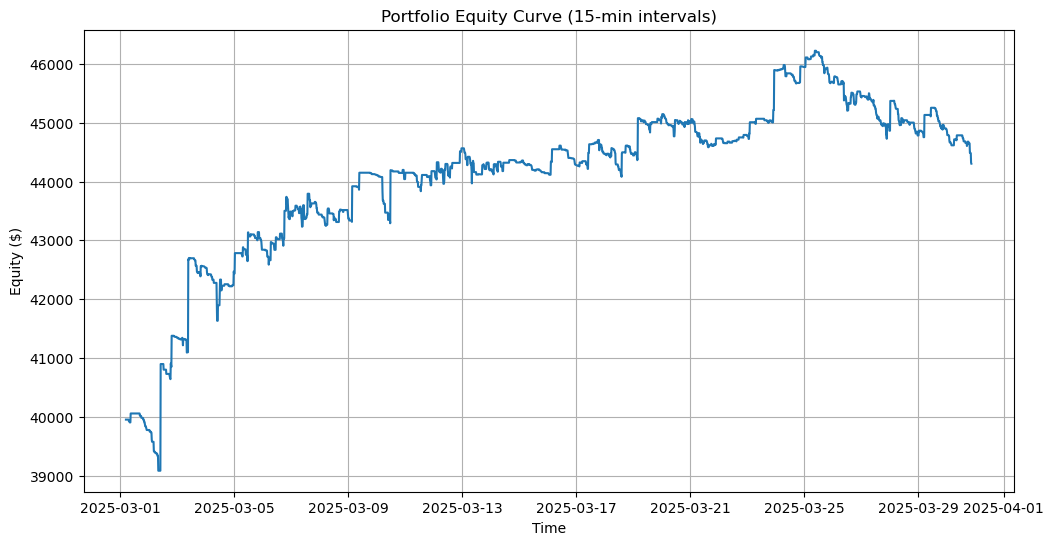

In [26]:
# 1. Concatenate all equity curves
combined = pd.concat([
    BTCUSD_Optimal_curve,
    ETHUSD_Optimal_curve,
    EURUSD_Optimal_curve,
    USDJPY_Optimal_curve
])

combined.to_csv("optimal_curves.csv")

# 2. Create a complete datetime index covering your entire period
full_index = pd.date_range(
    start=combined['time'].min(),
    end=combined['time'].max(),
    freq='15T'  # 15 minute intervals
)

# 3. For each asset, reindex to the full timeline and forward-fill
assets = {
    'BTC': BTCUSD_Optimal_curve,
    'ETH': ETHUSD_Optimal_curve,
    'EUR': EURUSD_Optimal_curve,
    'JPY': USDJPY_Optimal_curve
}

filled_curves = {}
for name, df in assets.items():
    # Set time as index and reindex to full timeline
    temp = df.set_index('time').reindex(full_index)
    # Forward fill equity values
    temp['equity'] = temp['equity'].ffill()
    # Backfill initial NaN values if needed
    temp['equity'] = temp['equity'].bfill()
    filled_curves[name] = temp.reset_index()

# 4. Combine all filled curves
combined_filled = pd.concat(filled_curves.values())
combined_filled
total_equity = combined_filled.groupby('index')['equity'].sum().reset_index()

# 5. Plot
plt.figure(figsize=(12, 6))
plt.plot(total_equity['index'], total_equity['equity'], label="Total Equity")
plt.xlabel("Time")
plt.ylabel("Equity ($)")
plt.title("Portfolio Equity Curve (15-min intervals)")
plt.grid()
plt.show()